In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

In [2]:
MAX_MEMORY = '12G'
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

In [3]:
spark

### ВЫБОРКА

In [4]:
sc = spark.sparkContext
path = "itineraries.csv"
df1 = spark.read.csv(path, header=True, inferSchema=True)
df = df1.sample(fraction=0.001, seed=42)# сэмплинг
df.show()

+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode| segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segmen

In [5]:
df.count()

3994

In [6]:
df1.count()

3886982

### ТИПЫ ПРИЗНАКОВ

In [7]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: s

In [8]:
column_data_types = df.dtypes
column_data_types

[('legId', 'string'),
 ('searchDate', 'date'),
 ('flightDate', 'date'),
 ('startingAirport', 'string'),
 ('destinationAirport', 'string'),
 ('fareBasisCode', 'string'),
 ('travelDuration', 'string'),
 ('elapsedDays', 'int'),
 ('isBasicEconomy', 'boolean'),
 ('isRefundable', 'boolean'),
 ('isNonStop', 'boolean'),
 ('baseFare', 'double'),
 ('totalFare', 'double'),
 ('seatsRemaining', 'int'),
 ('totalTravelDistance', 'int'),
 ('segmentsDepartureTimeEpochSeconds', 'string'),
 ('segmentsDepartureTimeRaw', 'string'),
 ('segmentsArrivalTimeEpochSeconds', 'string'),
 ('segmentsArrivalTimeRaw', 'string'),
 ('segmentsArrivalAirportCode', 'string'),
 ('segmentsDepartureAirportCode', 'string'),
 ('segmentsAirlineName', 'string'),
 ('segmentsAirlineCode', 'string'),
 ('segmentsEquipmentDescription', 'string'),
 ('segmentsDurationInSeconds', 'string'),
 ('segmentsDistance', 'string'),
 ('segmentsCabinCode', 'string')]

In [9]:
df = df.drop("searchDate", "flightDate", "segmentsDepartureTimeEpochSeconds", "segmentsDepartureTimeRaw", "segmentsArrivalTimeEpochSeconds", "segmentsArrivalTimeRaw", "segmentsAirlineName", 
            "segmentsEquipmentDescription", "segmentsDurationInSeconds", "segmentsDistance", "segmentsArrivalAirportCode", "segmentsDepartureAirportCode", "segmentsAirlineCode", 
            "segmentsCabinCode")

In [10]:
column_data_types = df.dtypes
column_data_types

[('legId', 'string'),
 ('startingAirport', 'string'),
 ('destinationAirport', 'string'),
 ('fareBasisCode', 'string'),
 ('travelDuration', 'string'),
 ('elapsedDays', 'int'),
 ('isBasicEconomy', 'boolean'),
 ('isRefundable', 'boolean'),
 ('isNonStop', 'boolean'),
 ('baseFare', 'double'),
 ('totalFare', 'double'),
 ('seatsRemaining', 'int'),
 ('totalTravelDistance', 'int')]

In [11]:
from tabulate import tabulate
table = tabulate(df.dtypes, headers=["Column Name", "Data Type"], tablefmt="pretty")
print(table)

+---------------------+-----------+
|     Column Name     | Data Type |
+---------------------+-----------+
|        legId        |  string   |
|   startingAirport   |  string   |
| destinationAirport  |  string   |
|    fareBasisCode    |  string   |
|   travelDuration    |  string   |
|     elapsedDays     |    int    |
|   isBasicEconomy    |  boolean  |
|    isRefundable     |  boolean  |
|      isNonStop      |  boolean  |
|      baseFare       |  double   |
|      totalFare      |  double   |
|   seatsRemaining    |    int    |
| totalTravelDistance |    int    |
+---------------------+-----------+


### ПРОПУЩЕННЫЕ

In [12]:
from pyspark.sql.functions import coalesce
# Определение типов столбцов
string_columns = [col_name for (col_name, col_type) in df.dtypes if col_type == 'string']
numeric_columns = [col_name for (col_name, col_type) in df.dtypes if col_type in ('double', 'int')]
boolean_columns = [col_name for (col_name, col_type) in df.dtypes if col_type == 'boolean']

# Подсчет пропущенных значений
missing_values = {col: df.filter(coalesce(df[col].isNull(), df[col].eqNullSafe(None))).count() for col in df.columns}
print("Пропущенные значения:")
for feature, count in missing_values.items():
    print(f"{feature}: {count}")

# Удаление строк с пропущенными значениями
columns_to_clean = string_columns + numeric_columns + boolean_columns
df_cleaned = df.na.drop(subset=columns_to_clean)

# Отображение результатов
df_cleaned.show()

# Подсчет числа строк до и после удаления
num_rows_before = df.count()
num_rows_after = df_cleaned.count()
print(f"Количество строк до удаления: {num_rows_before}")
print(f"Количество строк после удаления: {num_rows_after}")

Пропущенные значения:
legId: 0
startingAirport: 0
destinationAirport: 0
fareBasisCode: 0
travelDuration: 0
elapsedDays: 0
isBasicEconomy: 0
isRefundable: 0
isNonStop: 0
baseFare: 0
totalFare: 0
seatsRemaining: 0
totalTravelDistance: 255
+--------------------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|002ae21f5d6f9f470...|            PHL|               LAX|     QA0NA0MQ|       PT8H20M|          0|         false|       false|    false|  322.79|    370.6|             6|               2512|

In [13]:
# Подсчет пропущенных значений после удаления
missing_values_after_drop = {col: df_cleaned.filter(df_cleaned[col].isNull() | df_cleaned[col].eqNullSafe(None)).count() for col in df_cleaned.columns}
print("Пропущенные значения после удаления:")
for feature, count in missing_values_after_drop.items():
    print(f"{feature}: {count}")

Пропущенные значения после удаления:
legId: 0
startingAirport: 0
destinationAirport: 0
fareBasisCode: 0
travelDuration: 0
elapsedDays: 0
isBasicEconomy: 0
isRefundable: 0
isNonStop: 0
baseFare: 0
totalFare: 0
seatsRemaining: 0
totalTravelDistance: 0


In [14]:
df = df_cleaned

In [15]:
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)



### ВЫБРОСЫ

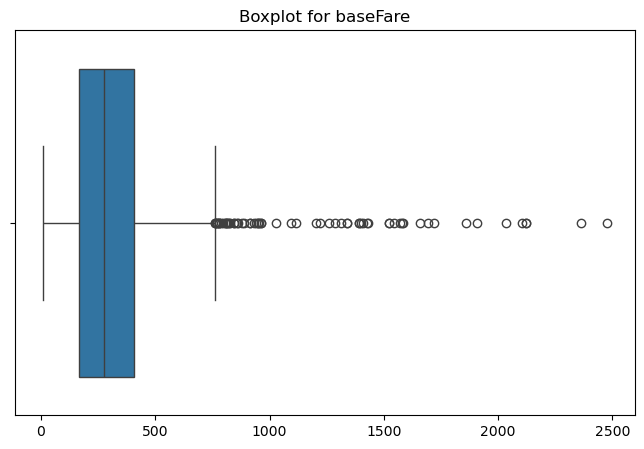

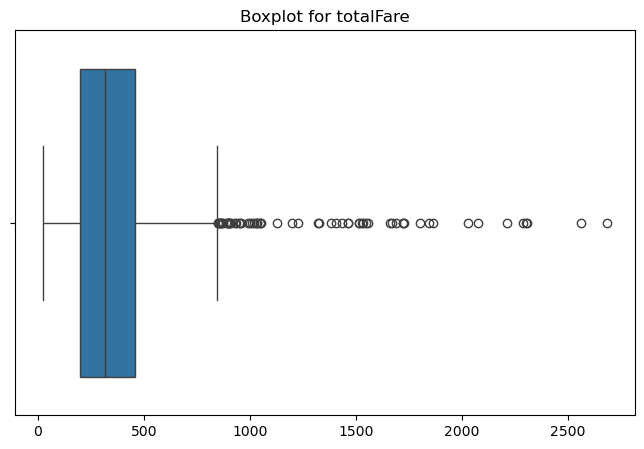

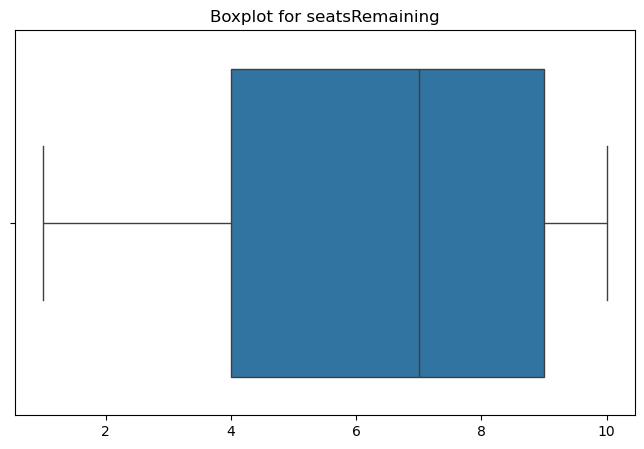

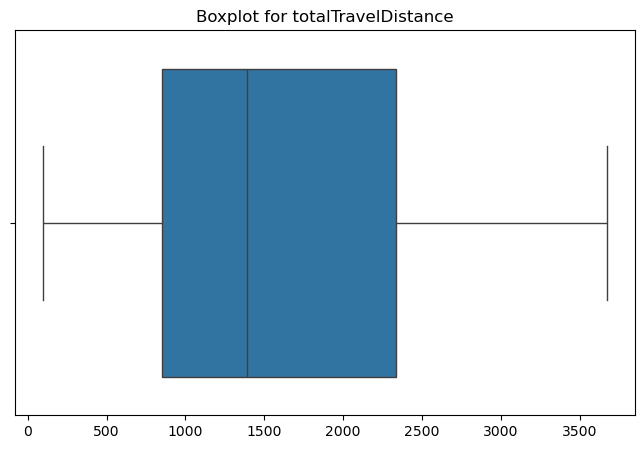

In [16]:
import seaborn as sns
# Функция для отображения усатых ящиков (boxplot)
def display_boxplot(dataframe, numeric_columns):
    for column in numeric_columns:
        data = dataframe.select(column).collect()
        data_values = [row[column] for row in data]
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=data_values, orient="h")
        plt.title(f'Boxplot for {column}')
        plt.show()

numeric_columns = ['baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
# Отобразим усатые ящики для выбранных числовых столбцов
display_boxplot(df, numeric_columns)

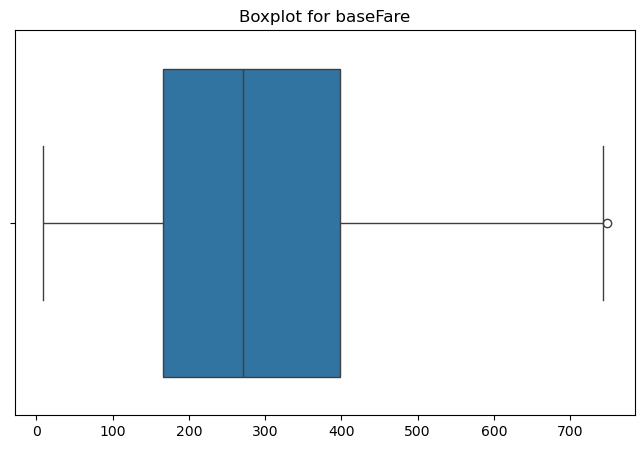

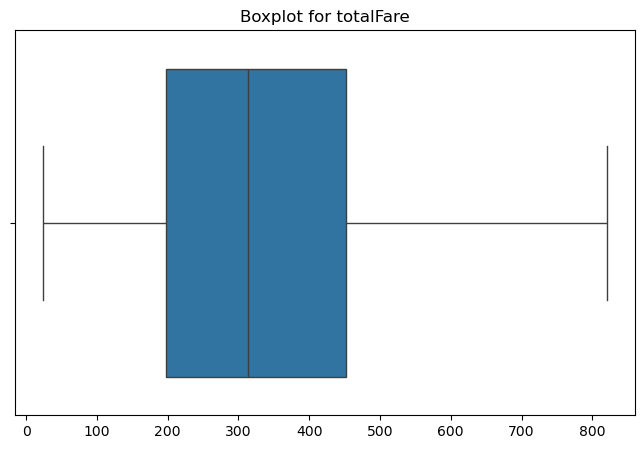

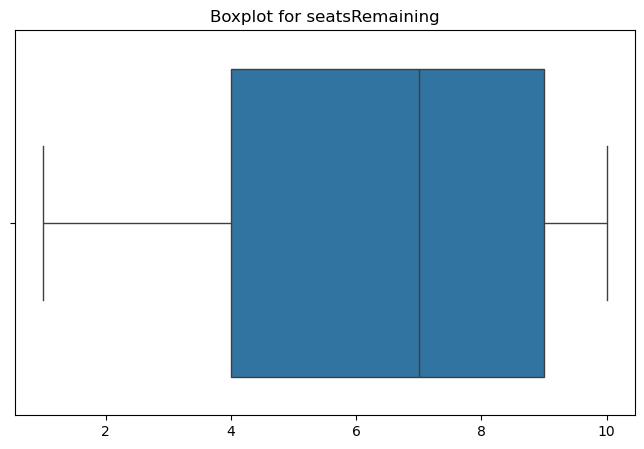

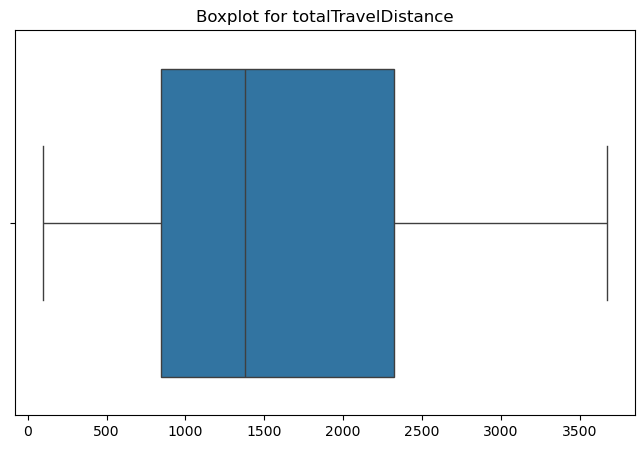

+--------------------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|               legId|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|
+--------------------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+
|002ae21f5d6f9f470...|            PHL|               LAX|     QA0NA0MQ|       PT8H20M|          0|         false|       false|    false|  322.79|    370.6|             6|               2512|
|7105aa1fd1ab48547...|            PHL|               LGA|     KA0NX0MQ|       PT5H24M|          0|         false|       false|    false|  388.83|   441.59|             9|               1429|
|4fe3b785aae2645cc...|            SFO|       

In [17]:
# Функция для определения выбросов и удаления их из датасета
def remove_outliers(dataframe, numeric_columns):
    for column in numeric_columns:
        # квартили для определения выбросов
        Q1 = dataframe.approxQuantile(column, [0.25], 0.01)[0]
        Q3 = dataframe.approxQuantile(column, [0.75], 0.01)[0]
        IQR = Q3 - Q1

        # Определение границ для выбросов
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Удаление выбросов
        dataframe = dataframe.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return dataframe

# Удалить выбросы из датасета
new_dataset_no_outliers = remove_outliers(df, numeric_columns)

# усатые ящики для нового датасета без выбросов
display_boxplot(new_dataset_no_outliers, numeric_columns)

# первые строки нового датасета без выбросов
new_dataset_no_outliers.show()

In [18]:
df2 = new_dataset_no_outliers
num_rows_before = df.count()
print(f"Количество строк до удаления: {num_rows_before}")

# Выведем количество строк после удаления выбросов
print(f"Количество строк после удаления выбросов: {df2.count()}")

Количество строк до удаления: 3739
Количество строк после удаления выбросов: 3671


+--------------+-----+
|isBasicEconomy|count|
+--------------+-----+
|          true|  319|
|         false| 3352|
+--------------+-----+

+------------+-----+
|isRefundable|count|
+------------+-----+
|       false| 3671|
+------------+-----+

+---------+-----+
|isNonStop|count|
+---------+-----+
|     true| 1163|
|    false| 2508|
+---------+-----+



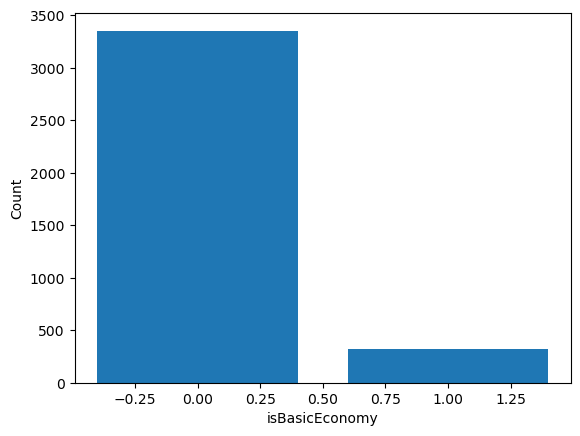

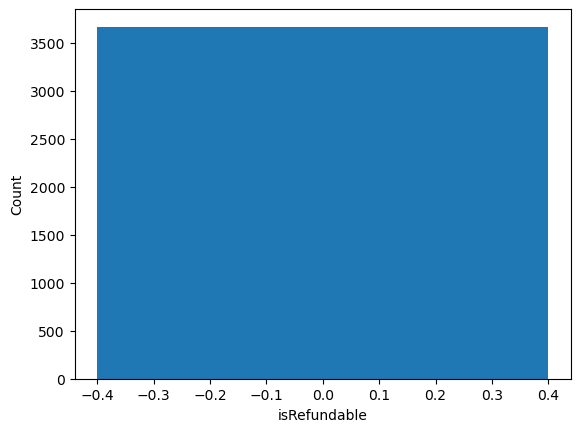

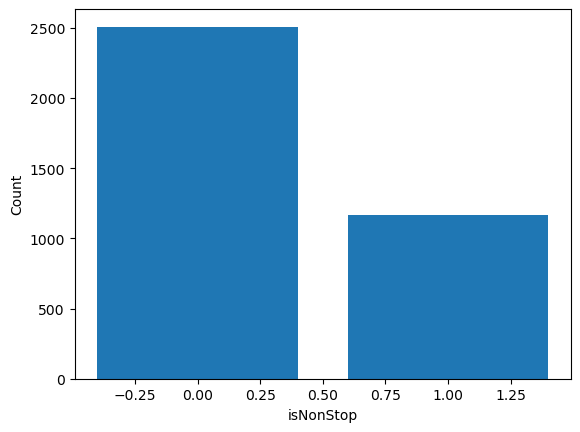

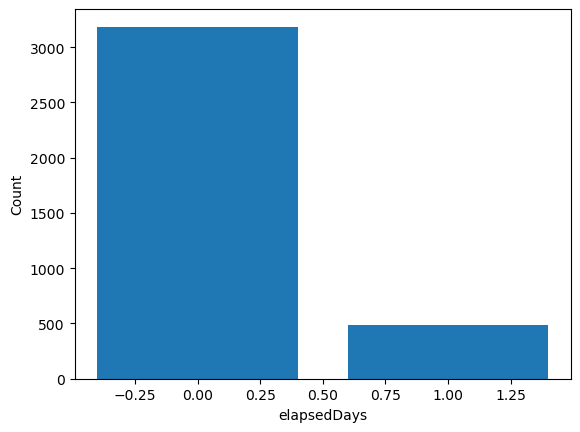

+---------+------------------+
|isNonStop|    avg(totalFare)|
+---------+------------------+
|     true|250.31221840068756|
|    false| 374.8029146730464|
+---------+------------------+



In [19]:
df2.groupBy('isBasicEconomy').count().show()
df2.groupBy('isRefundable').count().show()
df2.groupBy('isNonStop').count().show()

def plot_boolean_distribution(df, column_name):
    data = df2.groupBy(column_name).count().take(1000)
    labels = [row[column_name] for row in data]
    counts = [row['count'] for row in data]

    plt.bar(labels, counts)
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.show()

plot_boolean_distribution(df2, 'isBasicEconomy')
plot_boolean_distribution(df2, 'isRefundable')
plot_boolean_distribution(df2, 'isNonStop')
plot_boolean_distribution(df2, 'elapsedDays')

df2.groupBy('isNonStop').agg({'totalFare': 'mean'}).show()

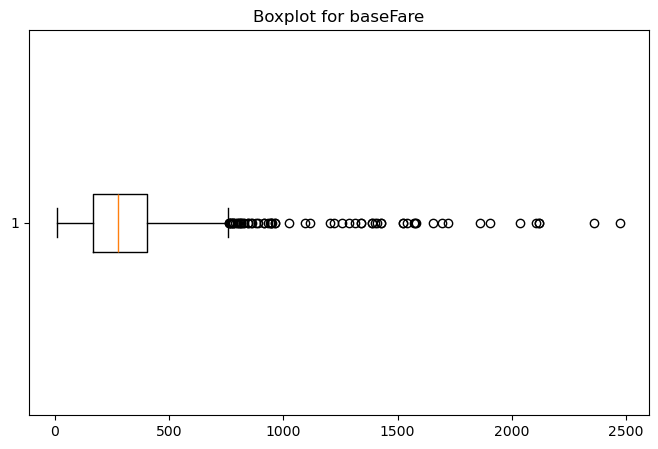

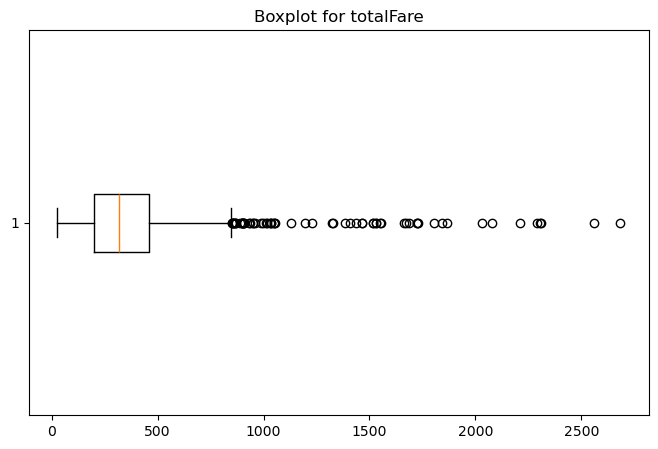

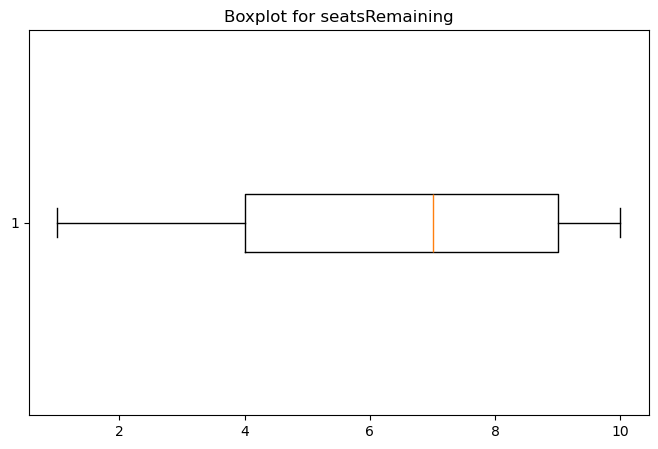

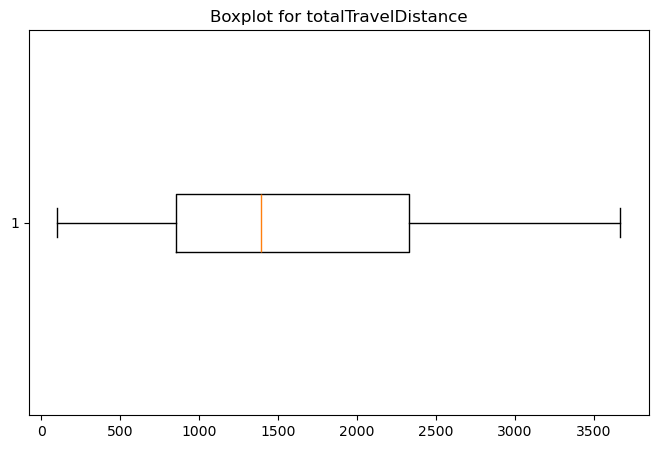

In [20]:
import matplotlib.pyplot as plt

def display_boxplot_handmade(dataframe, numeric_columns):
    for column in numeric_columns:
        # Собрем данные для усатого ящика
        data = dataframe.select(column).collect()
        data_values = [row[column] for row in data]

        # Определим квартили
        Q1 = np.percentile(data_values, 25)
        Q3 = np.percentile(data_values, 75)
        IQR = Q3 - Q1

        # Определим границы для усатых ящиков
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Отобразим усача
        plt.figure(figsize=(8, 5))
        plt.boxplot(data_values, vert=False)
        plt.title(f'Boxplot for {column}')
        plt.show()

# Отобразить усатые ящики для выбранных числовых столбцов вручную
display_boxplot_handmade(df, numeric_columns)


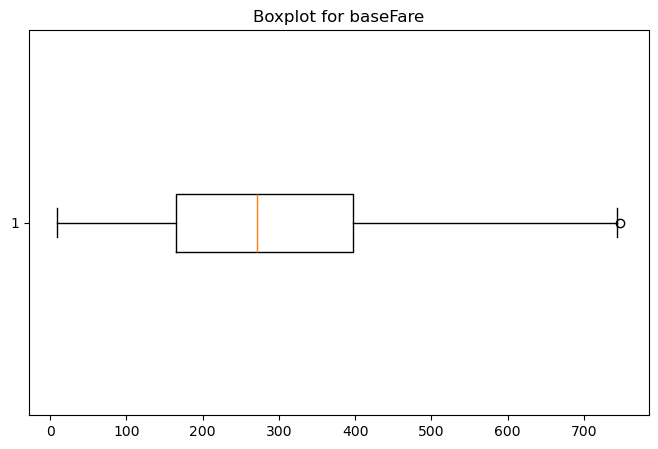

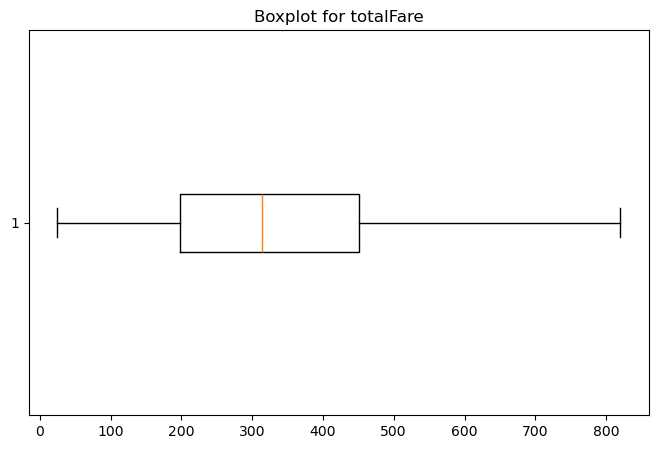

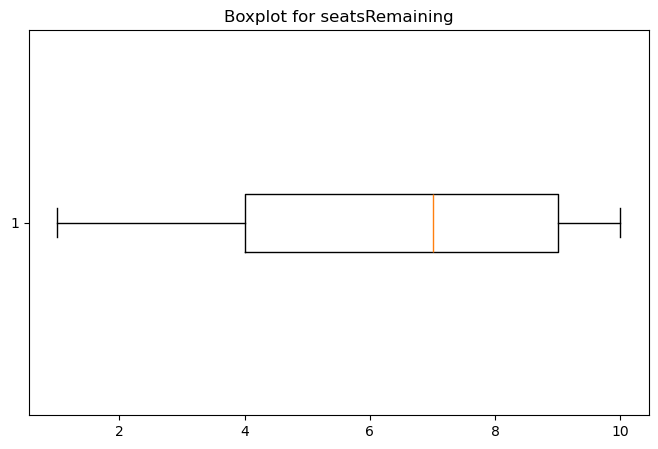

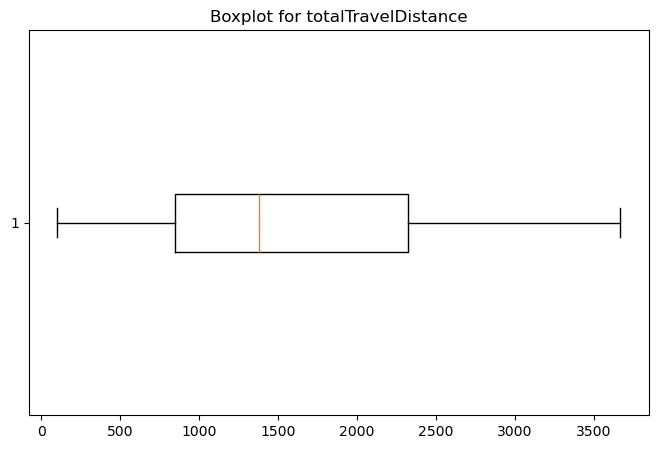

In [21]:
import matplotlib.pyplot as plt

# Отобразить усатые ящики для выбранных числовых столбцов
display_boxplot_handmade(df2, numeric_columns)

In [22]:
df = df2

### СТАТИСТИКА

In [23]:
# Вычисление статистических показателей для числовых признаков
#numeric_columns = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']
from pyspark.sql.functions import col, max, min, mean


# Подсчет средних значений
means = df.agg(*(mean(col(c)).alias(c) for c in numeric_columns)).collect()[0]

# Подсчет квартилей
quartiles = df.approxQuantile(numeric_columns, [0.25, 0.5, 0.75], 0.05)

# Вывод результатов
print("\nСредние значения:")
for col_name, mean_value in zip(numeric_columns, means):
    print(f"{col_name}: {mean_value:.2f}")

print("\nКвартили:")
for col_name, quartile_values in zip(numeric_columns, quartiles):
    q3, q2, q1 = quartile_values
    print(f"{col_name}: Q1={q1:.2f}, Median={q2:.2f}, Q3={q3:.2f}")


Средние значения:
baseFare: 291.78
totalFare: 335.36
seatsRemaining: 6.13
totalTravelDistance: 1541.84

Квартили:
baseFare: Q1=377.67, Median=262.32, Q3=167.44
totalFare: Q1=429.10, Median=301.60, Q3=197.10
seatsRemaining: Q1=8.00, Median=7.00, Q3=4.00
totalTravelDistance: Q1=2087.00, Median=1345.00, Q3=776.00


In [24]:
# квартили для выбранных столбцов
df.select("baseFare", "totalFare", "seatsRemaining").summary("25%", "50%", "75%").show()

+-------+--------+---------+--------------+
|summary|baseFare|totalFare|seatsRemaining|
+-------+--------+---------+--------------+
|    25%|  165.58|    197.6|             4|
|    50%|   270.7|    313.6|             7|
|    75%|  398.13|    451.6|             9|
+-------+--------+---------+--------------+



In [25]:
from pyspark.sql import functions as F

# Вычисляем средние значения
mean_values = df.select(F.mean("baseFare").alias("mean_baseFare"),
                        F.mean("totalFare").alias("mean_totalFare"),
                        F.mean("seatsRemaining").alias("mean_seatsRemaining"))

# Округляем средние значения до целых чисел
mean_values_rounded = mean_values.select(
    F.round("mean_baseFare", 0).alias("mean_baseFare"),
    F.round("mean_totalFare", 0).alias("mean_totalFare"),
    F.round("mean_seatsRemaining", 0).alias("mean_seatsRemaining")
)

mean_values_rounded.show()


+-------------+--------------+-------------------+
|mean_baseFare|mean_totalFare|mean_seatsRemaining|
+-------------+--------------+-------------------+
|        292.0|         335.0|                6.0|
+-------------+--------------+-------------------+



In [26]:
from pyspark.sql.functions import col

result = df.groupBy("startingAirport").agg({"seatsRemaining": "mean"}) \
           .withColumn("avg(seatsRemaining)", col("avg(seatsRemaining)").cast("int"))

result.show()


+---------------+-------------------+
|startingAirport|avg(seatsRemaining)|
+---------------+-------------------+
|            OAK|                  5|
|            LGA|                  6|
|            BOS|                  6|
|            EWR|                  6|
|            DEN|                  5|
|            IAD|                  6|
|            CLT|                  5|
|            MIA|                  6|
|            DFW|                  6|
|            SFO|                  5|
|            ATL|                  6|
|            ORD|                  6|
|            DTW|                  6|
|            LAX|                  6|
|            JFK|                  6|
|            PHL|                  5|
+---------------+-------------------+



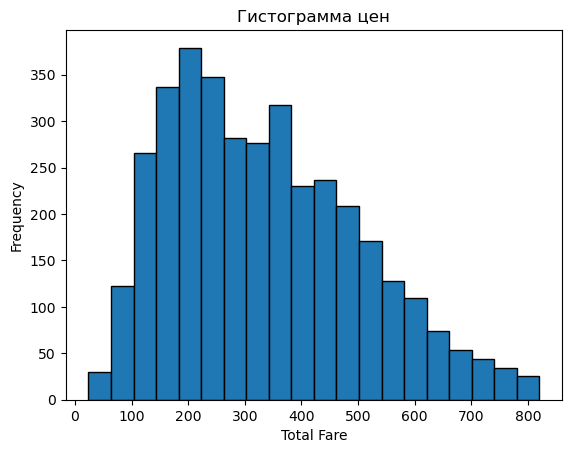

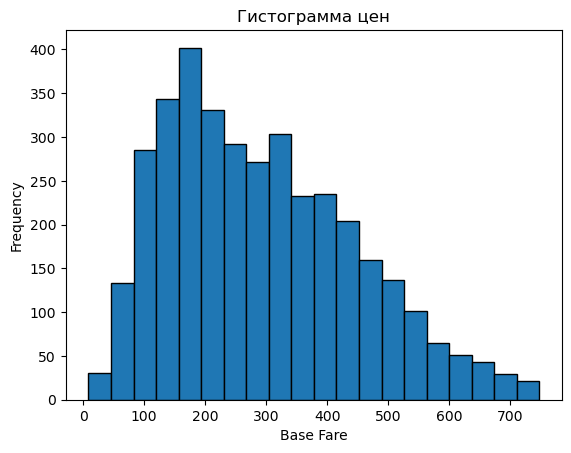

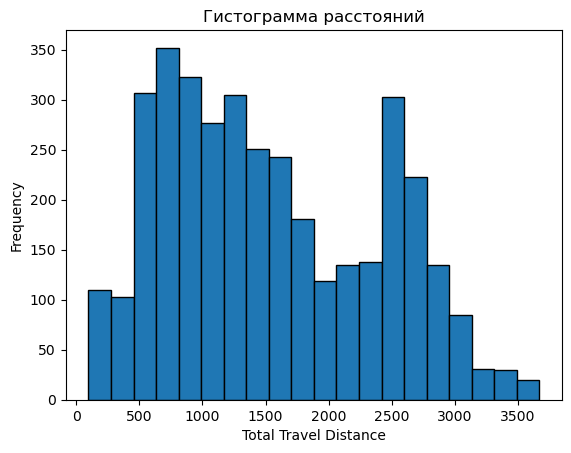

In [27]:
# столбец "baseFare" и его в RDD
baseFare_data = df.select("baseFare").rdd.flatMap(lambda x: x)
# данные в список
baseFare_list = baseFare_data.collect()

# столбец "totalFare" и его в RDD
totalFare_data = df.select("totalFare").rdd.flatMap(lambda x: x)
# данные в список
totalFare_list = totalFare_data.collect()

# столбец "baseFare" и его в RDD
totalTravelDistance_data = df.select("totalTravelDistance").rdd.flatMap(lambda x: x)
# данные в список
totalTravelDistance_list = totalTravelDistance_data.collect()

plt.hist(totalFare_list, bins=20, edgecolor="k")
plt.xlabel("Total Fare")
plt.ylabel("Frequency")
plt.title("Гистограмма цен")
plt.show()

plt.hist(baseFare_list, bins=20, edgecolor="k")
plt.xlabel("Base Fare")
plt.ylabel("Frequency")
plt.title("Гистограмма цен")
plt.show()

plt.hist(totalTravelDistance_list, bins=20, edgecolor="k")
plt.xlabel("Total Travel Distance")
plt.ylabel("Frequency")
plt.title("Гистограмма расстояний")
plt.show()


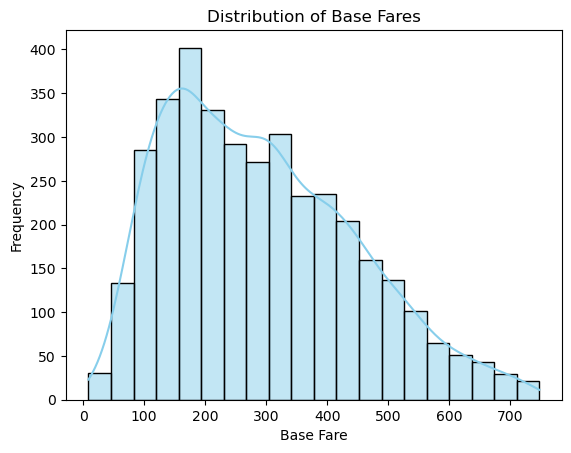

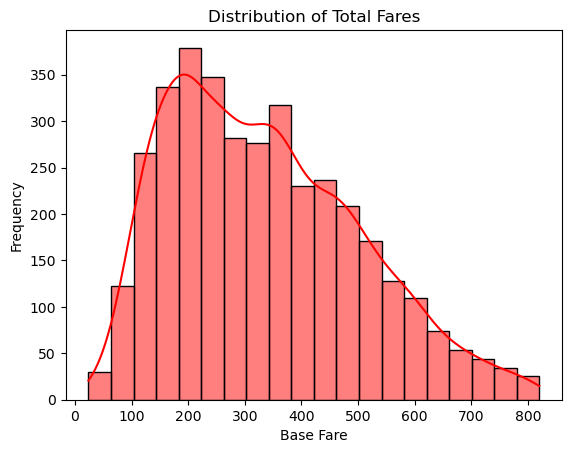

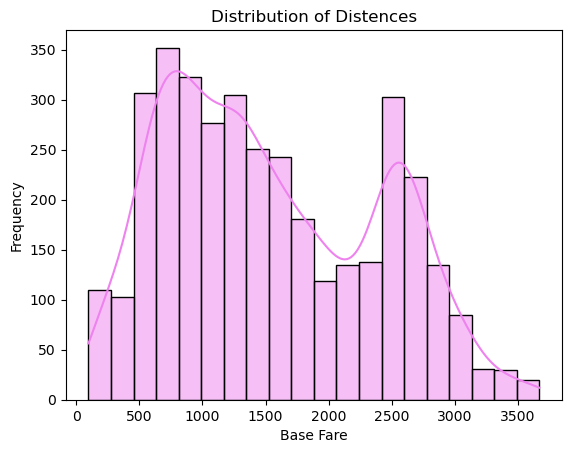

In [28]:
# допустим  для столбца 'baseFare'
sns.histplot(baseFare_list, bins=20, kde=True, color='skyblue', edgecolor='black')
plt.xlabel("Base Fare")
plt.ylabel("Frequency")
plt.title("Distribution of Base Fares")
plt.show()


sns.histplot(totalFare_list, bins=20, kde=True, color='red', edgecolor='black')
plt.xlabel("Base Fare")
plt.ylabel("Frequency")
plt.title("Distribution of Total Fares")
plt.show()

sns.histplot(totalTravelDistance_list, bins=20, kde=True, color='violet', edgecolor='black')
plt.xlabel("Base Fare")
plt.ylabel("Frequency")
plt.title("Distribution of Distences")
plt.show()

In [29]:
from pyspark.sql.functions import col, mean, stddev, count

summary_stats = df.agg(
    *(mean(col(c)).alias(f"{c}_mean") for c in numeric_columns),
    *(min(col(c)).alias(f"{c}_min") for c in numeric_columns),
    *(max(col(c)).alias(f"{c}_max") for c in numeric_columns),
    *(stddev(col(c)).alias(f"{c}_stddev") for c in numeric_columns),
    count("*").alias("count_col")  # Поменяли count("*") на count
)

summary_stats.show()


+-----------------+-----------------+-------------------+------------------------+------------+-------------+------------------+-----------------------+------------+-------------+------------------+-----------------------+------------------+------------------+---------------------+--------------------------+---------+
|    baseFare_mean|   totalFare_mean|seatsRemaining_mean|totalTravelDistance_mean|baseFare_min|totalFare_min|seatsRemaining_min|totalTravelDistance_min|baseFare_max|totalFare_max|seatsRemaining_max|totalTravelDistance_max|   baseFare_stddev|  totalFare_stddev|seatsRemaining_stddev|totalTravelDistance_stddev|count_col|
+-----------------+-----------------+-------------------+------------------------+------------+-------------+------------------+-----------------------+------------+-------------+------------------+-----------------------+------------------+------------------+---------------------+--------------------------+---------+
|291.7831408335603|335.3633396894591|   

In [30]:
'''Среднее значение (mean): Это среднее значение для каждого числового столбца. Например, средняя цена билета, среднее количество оставшихся мест и так далее.

Минимальное значение (min): Это самое низкое значение в каждом числовом столбце. Например, минимальная цена билета, минимальное количество оставшихся мест и т. д.

Максимальное значение (max): Это самое высокое значение в каждом числовом столбце. Например, максимальная цена билета, максимальное количество оставшихся мест и т. д.

Стандартное отклонение (stddev): Это мера разброса значений в столбце относительно их среднего значения. Чем больше стандартное отклонение, тем больше разброс в данных.

Количество строк (count): Это общее количество строк (например, записей о перелетах)'''

'Среднее значение (mean): Это среднее значение для каждого числового столбца. Например, средняя цена билета, среднее количество оставшихся мест и так далее.\n\nМинимальное значение (min): Это самое низкое значение в каждом числовом столбце. Например, минимальная цена билета, минимальное количество оставшихся мест и т. д.\n\nМаксимальное значение (max): Это самое высокое значение в каждом числовом столбце. Например, максимальная цена билета, максимальное количество оставшихся мест и т. д.\n\nСтандартное отклонение (stddev): Это мера разброса значений в столбце относительно их среднего значения. Чем больше стандартное отклонение, тем больше разброс в данных.\n\nКоличество строк (count): Это общее количество строк (например, записей о перелетах)'

In [31]:
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9]

# Вычисление приближенных позиций (фрагментов на дискретном пространстве, слово перцентиль мне не нравится) для выбранных столбцов
quantiles = df2.approxQuantile(numeric_columns, percentiles, 0.05)

# Вывод результатов
print("\nПриближенные позиции:")
for col_name, quantile_values in zip(numeric_columns, quantiles):
    p10, p25, p50, p75, p90 = quantile_values
    print(f"{col_name}: P10={p10:.2f}, P25={p25:.2f}, Median={p50:.2f}, P75={p75:.2f}, P90={p90:.2f}")


Приближенные позиции:
baseFare: P10=106.05, P25=167.44, Median=262.32, P75=377.67, P90=463.26
totalFare: P10=128.60, P25=197.10, Median=301.60, P75=429.10, P90=527.21
seatsRemaining: P10=2.00, P25=4.00, Median=7.00, P75=8.00, P90=9.00
totalTravelDistance: P10=541.00, P25=776.00, Median=1345.00, P75=2087.00, P90=2595.00


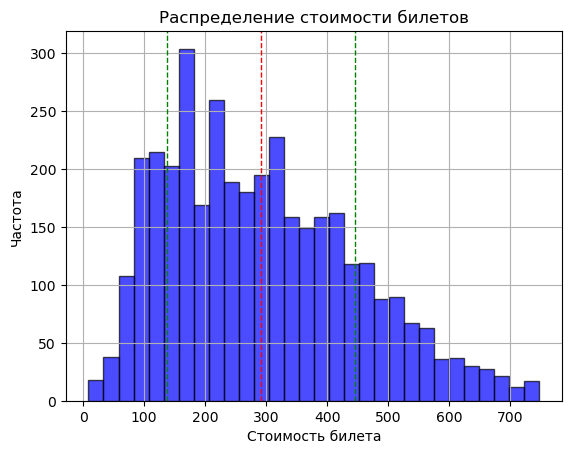

In [32]:
# Расчет статистических показателей
mean_value = df.agg(functions.mean('baseFare')).collect()[0][0]
std_deviation = df.agg(functions.stddev('baseFare')).collect()[0][0]

# Визуализация распределения с помощью гистограммы
fare_values = df.select('baseFare').rdd.flatMap(lambda x: x).collect()

plt.hist(fare_values, bins=30, alpha=0.7, color='blue', edgecolor='black') # гистограмма распределения стоимости билетов
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1) # среднее значение стоимости билетов
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=1) # значения, находящиеся на одно стандартное отклонение влево
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=1) # и вправо от среднего значения

plt.title('Распределение стоимости билетов')
plt.xlabel('Стоимость билета')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

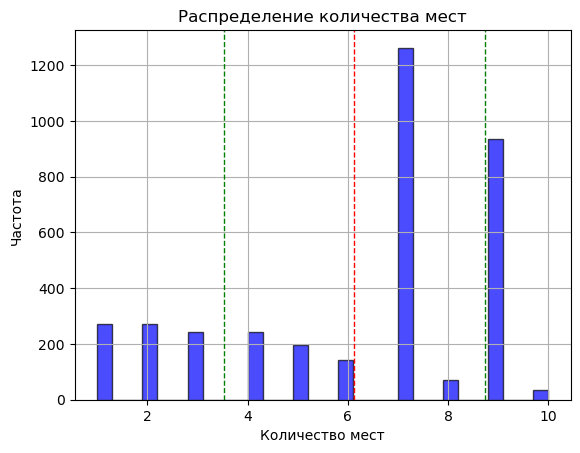

In [33]:
mean_value = df.agg(functions.mean('seatsRemaining')).collect()[0][0]
std_deviation = df.agg(functions.stddev('seatsRemaining')).collect()[0][0]
fare_values = df.select('seatsRemaining').rdd.flatMap(lambda x: x).collect()
plt.hist(fare_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.title('Распределение количества мест')
plt.xlabel('Количество мест')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

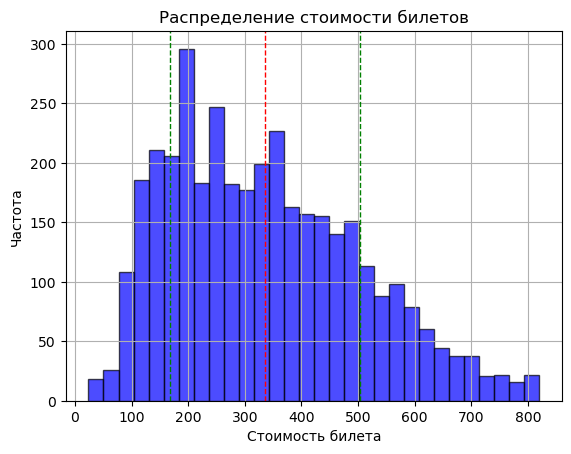

In [34]:
mean_value = df.agg(functions.mean('totalFare')).collect()[0][0]
std_deviation = df.agg(functions.stddev('totalFare')).collect()[0][0]
fare_values = df.select('totalFare').rdd.flatMap(lambda x: x).collect()
plt.hist(fare_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.title('Распределение стоимости билетов')
plt.xlabel('Стоимость билета')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

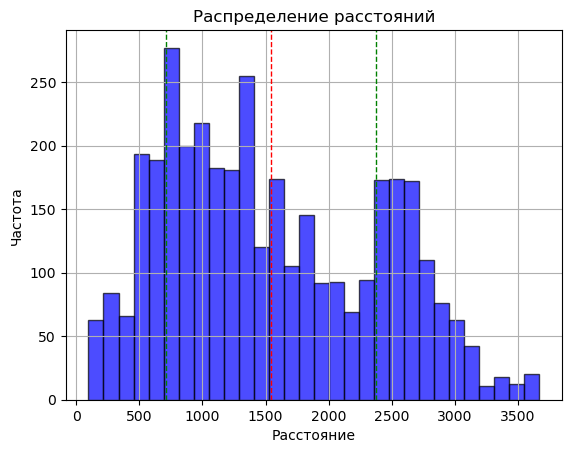

In [35]:
mean_value = df.agg(functions.mean('totalTravelDistance')).collect()[0][0]
std_deviation = df.agg(functions.stddev('totalTravelDistance')).collect()[0][0]
fare_values = df.select('totalTravelDistance').rdd.flatMap(lambda x: x).collect()
plt.hist(fare_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)
plt.axvline(mean_value - std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.axvline(mean_value + std_deviation, color='green', linestyle='dashed', linewidth=1)
plt.title('Распределение расстояний')
plt.xlabel('Расстояние')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

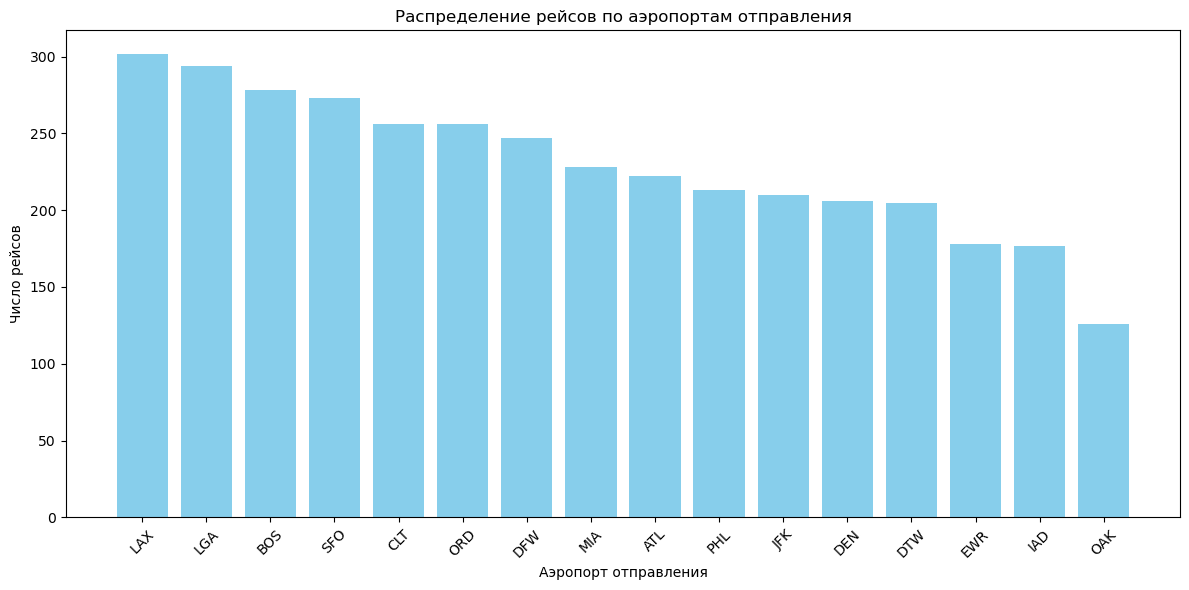

In [36]:
# Выбор категориального признака
airport_counts = df.groupBy('startingAirport').count().orderBy('count', ascending=False).collect()
# Преобразование данных для визуализации
airports = [item[0] for item in airport_counts]
counts = [item[1] for item in airport_counts]
plt.figure(figsize=(12, 6))  
plt.bar(airports, counts, color='skyblue')
# Добавление меток и заголовка
plt.xlabel('Аэропорт отправления')
plt.ylabel('Число рейсов')
plt.title('Распределение рейсов по аэропортам отправления')
plt.xticks(rotation=45)  # Поворот меток на оси x для улучшения читаемости
plt.tight_layout()  # Улучшение отображения меток
plt.show()

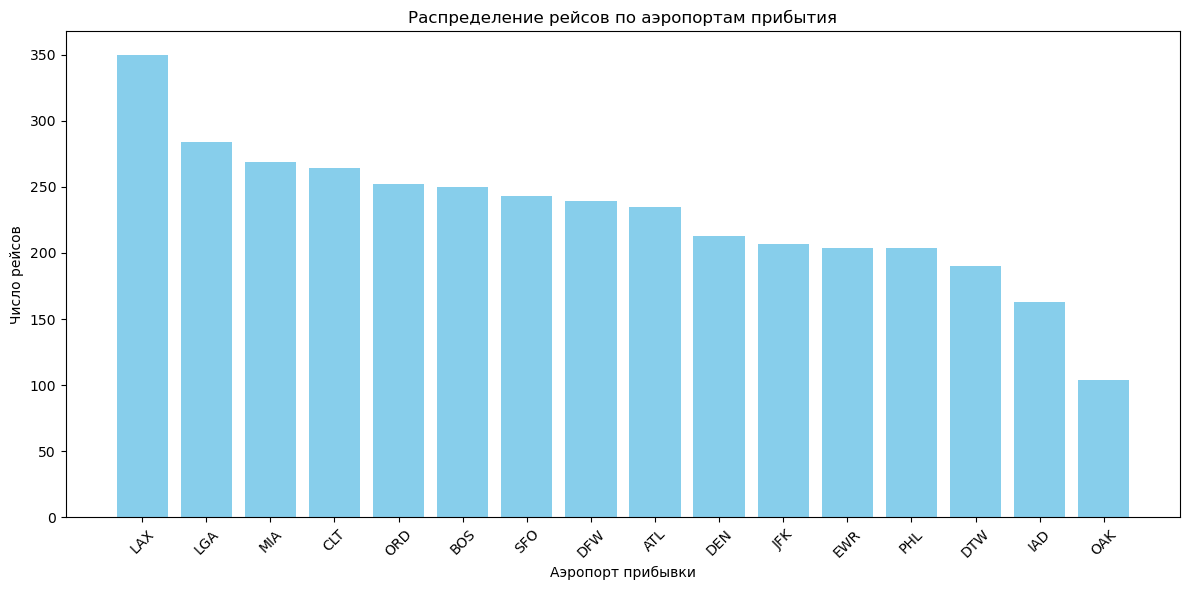

In [40]:
airport_counts = df.groupBy('destinationAirport').count().orderBy('count', ascending=False).collect()
airports = [item[0] for item in airport_counts]
counts = [item[1] for item in airport_counts]
plt.figure(figsize=(12, 6))  
plt.bar(airports, counts, color='skyblue')
plt.xlabel('Аэропорт прибывки')
plt.ylabel('Число рейсов')
plt.title('Распределение рейсов по аэропортам прибытия')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

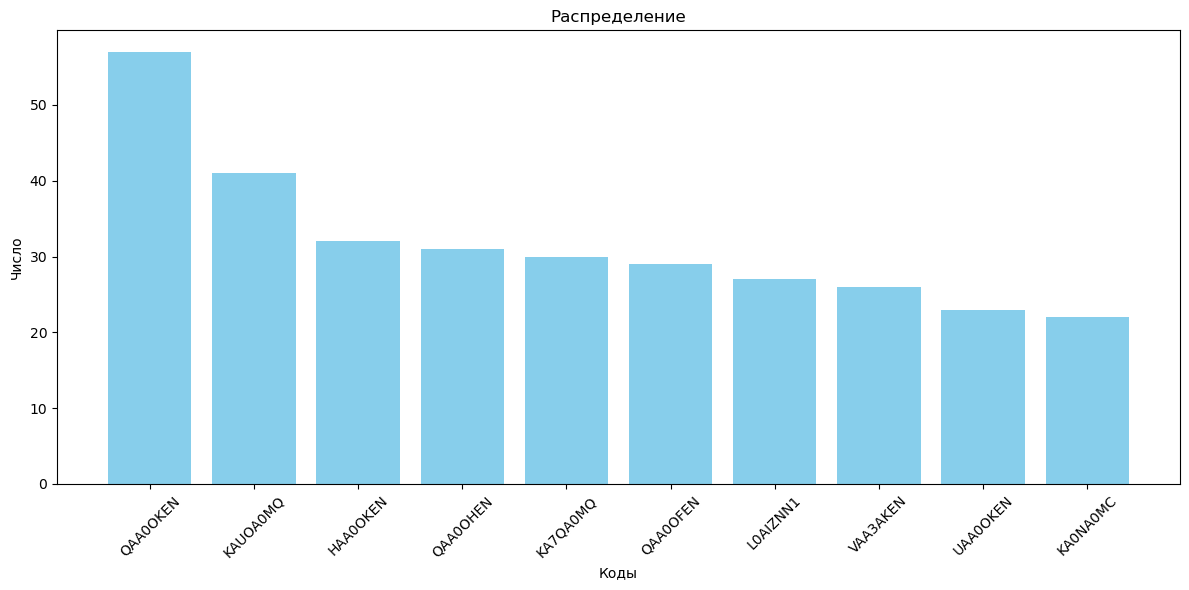

In [41]:
N = 10
airport_counts = df.groupBy('fareBasisCode').count().orderBy('count', ascending=False).limit(N).collect()
airports = [item[0] for item in airport_counts]
counts = [item[1] for item in airport_counts]
plt.figure(figsize=(12, 6)) 
plt.bar(airports, counts, color='skyblue')
plt.xlabel('Коды')
plt.ylabel('Число')
plt.title('Распределение')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


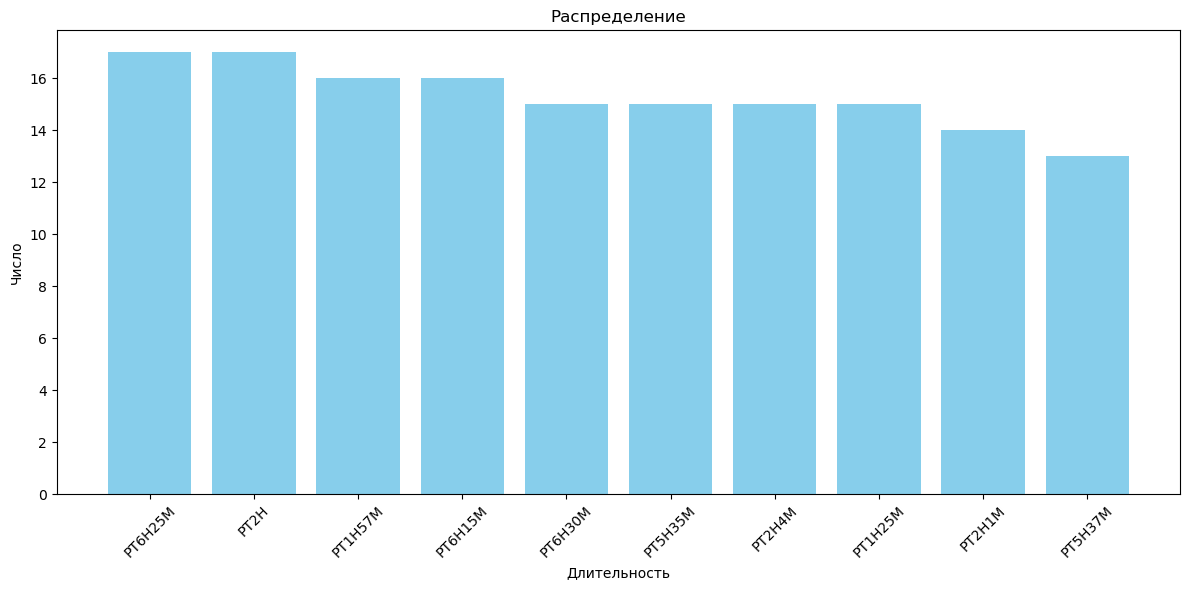

In [42]:
N = 10
airport_counts = df.groupBy('travelDuration').count().orderBy('count', ascending=False).limit(N).collect()
airports = [item[0] for item in airport_counts]
counts = [item[1] for item in airport_counts]
plt.figure(figsize=(12, 6)) 
plt.bar(airports, counts, color='skyblue')
plt.xlabel('Длительность')
plt.ylabel('Число')
plt.title('Распределение')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### РАСПРЕДЕЛЕНИЕ

In [43]:
# частоты категорий
category_frequencies = df.groupBy(*string_columns).agg(count("*").alias("frequency")).orderBy("frequency", ascending=False)

category_frequencies.show()

+--------------------+---------------+------------------+-------------+--------------+---------+
|               legId|startingAirport|destinationAirport|fareBasisCode|travelDuration|frequency|
+--------------------+---------------+------------------+-------------+--------------+---------+
|d5f2338f1d56f8abb...|            LAX|               DFW|     VAA3AKEN|       PT5H15M|        2|
|c410b20e50216eb4d...|            MIA|               DFW|     SUAIZSN3|       PT5H49M|        2|
|9b304b98db7fb31fd...|            MIA|               ORD|     QAA0OKEN|       PT3H25M|        2|
|1fbbb44fe71c36606...|            CLT|               MIA|     TA7NA0BG|       PT7H18M|        2|
|6c7938c50aadd048d...|            ATL|               ORD|     UL4ABEL1|       PT7H31M|        2|
|a6650b3a4c5e8808b...|            OAK|               EWR|     KA0NA0MC|       PT10H2M|        1|
|11421a003e1599082...|            OAK|               BOS|     NH0OAJMN|      PT12H45M|        1|
|a6867aacd73ea570d...|        

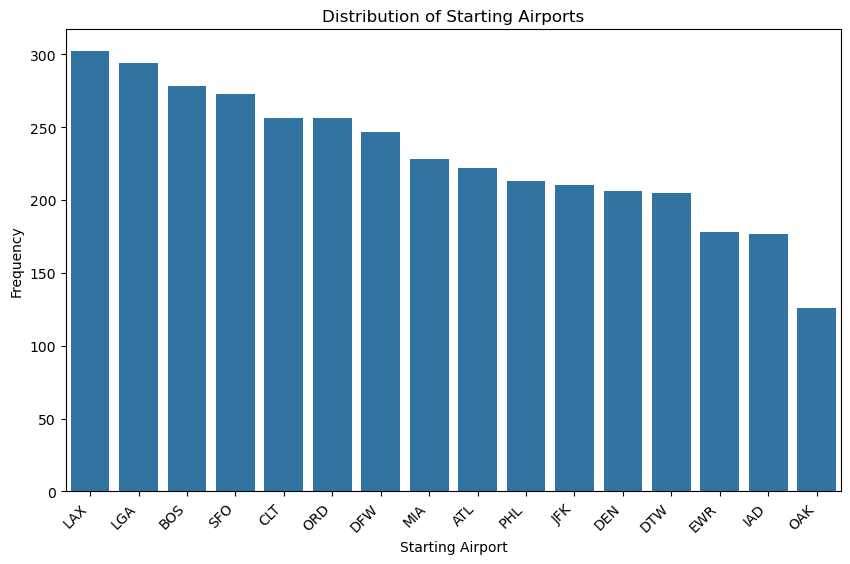

In [44]:
# groupBy и count для подсчета частот
starting_airport_counts = df.groupBy('startingAirport').count().orderBy('count', ascending=False)

# результат в массив NumPy
starting_airport_counts_array = starting_airport_counts.collect()

# данные для визуализации
starting_airports = [row['startingAirport'] for row in starting_airport_counts_array]
counts = [row['count'] for row in starting_airport_counts_array]

# Визуализация с использованием seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=starting_airports, y=counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Starting Airport")
plt.ylabel("Frequency")
plt.title("Distribution of Starting Airports")
plt.show()

### КОРРЕЛЯЦИЯ

In [45]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


# Выбираем только числовые признаки
#numeric_columns = ['elapsedDays', 'baseFare', 'totalFare', 'seatsRemaining', 'totalTravelDistance']

# Создаем вектор из числовых признаков
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
assembled_df = assembler.transform(df)

# Вычисляем корреляцию
correlation_matrix = Correlation.corr(assembled_df, "features").head()

# Печатаем матрицу корреляции
print("Correlation matrix:")
print(correlation_matrix[0])

Correlation matrix:
DenseMatrix([[ 1.        ,  0.9995351 , -0.09101277,  0.54822026],
             [ 0.9995351 ,  1.        , -0.09467404,  0.5537548 ],
             [-0.09101277, -0.09467404,  1.        , -0.07532951],
             [ 0.54822026,  0.5537548 , -0.07532951,  1.        ]])


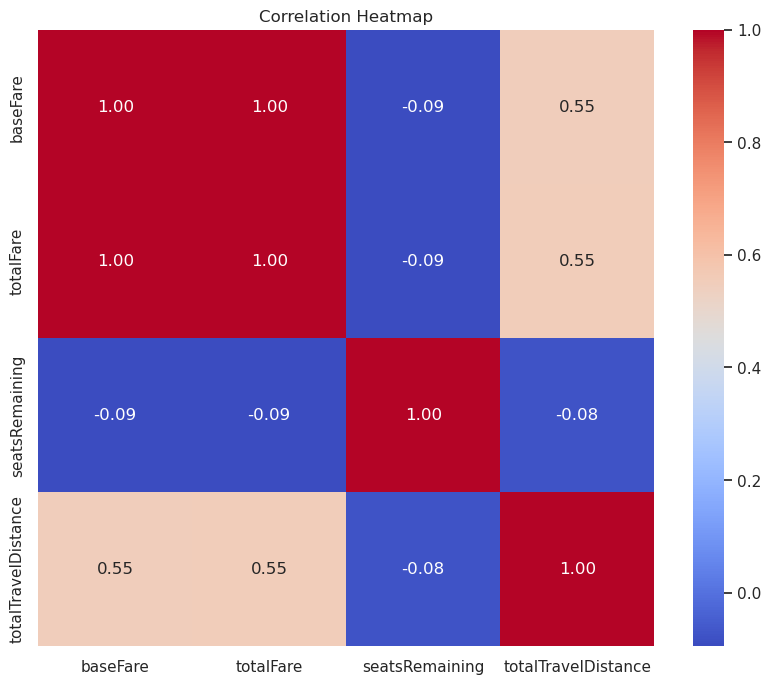

In [46]:
# Извлекаем матрицу корреляции из результатов
corr_matrix = correlation_matrix[0].toArray()

# Создаем хит... ХИТМАП!
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, xticklabels=numeric_columns, yticklabels=numeric_columns)
plt.title("Correlation Heatmap")
plt.show()